In [1]:
# Import all required dependencies
import pandas as pd
import numpy
import matplotlib.pyplot as plt 
import matplotlib.dates as dates
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Activation
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold

Using TensorFlow backend.


In [2]:
# Convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [3]:
# Hyperparameter
look_back = 10 # No of prev input used to predict next value
time_steps = 100 # No of time steps future prediction(s)
training_percent = 0.70

In [4]:
# series = pd.read_csv('S&P500.csv', header=0, usecols=[4])
series = pd.read_csv('S&P500.csv')
series['Date'] = pd.to_datetime(series.Date)
series = series.sort('Date')
series = series.reset_index(drop=True)

/Users/user/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [5]:
# Print the first 5 rows
print(series.head())

        Date   Open   High    Low  Close   Volume  Adjusted Close
0 1950-01-02  17.05  17.05  17.05  17.05  1810000           17.05
1 1950-01-03  17.24  17.24  17.24  17.24  1410000           17.24
2 1950-01-05  18.22  18.22  18.22  18.22  2390000           18.22
3 1950-01-06  18.77  18.77  18.77  18.77  1580000           18.77
4 1950-01-08  18.02  18.02  18.02  18.02  1970000           18.02


In [6]:
# Only get the Close column
new_df = series.drop('Date', 1)
new_df = new_df.drop('Open', 1)
new_df = new_df.drop('High', 1)
new_df = new_df.drop('Low', 1)
new_df = new_df.drop('Volume', 1)
new_df = new_df.drop('Adjusted Close', 1)

In [7]:
new_df

,Close
0,17.05
1,17.24
2,18.22
3,18.77
4,18.02
5,18.55
6,19.56
7,19.66
8,16.67
9,16.72


<IPython.core.display.Javascript object>


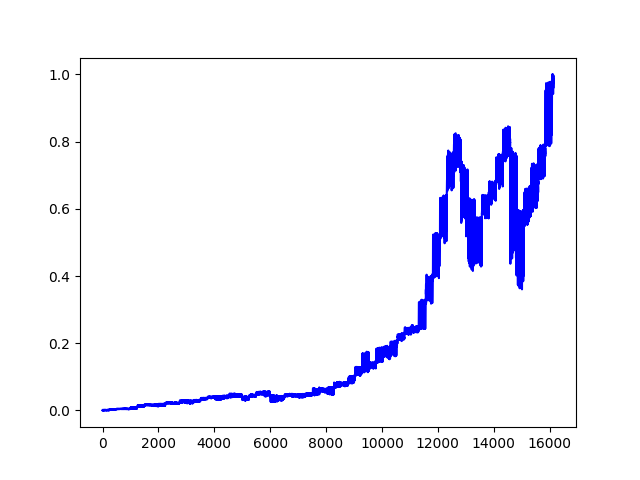

In [41]:
# Plot baseline and predictions
%matplotlib notebook

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
close_dataset_norm = scaler.fit_transform(new_df)

plt.plot(close_dataset_norm, color='b')
plt.show()

In [9]:
# Split into train and test sets (Training: 70%, Test: 30%)
train_size = int(len(close_dataset_norm) * training_percent)
test_size = len(close_dataset_norm) - train_size
train, test = close_dataset_norm[0:train_size,:], close_dataset_norm[train_size:len(close_dataset_norm),:]
print("Training datasets: ", len(train), ", Test datasets: ", len(test))
print("Training sets percentage (%):", float(training_percent)*100, ", Test sets percentage (%):", 100-float(training_percent)*100)

Training datasets:  11298 , Test datasets:  4843
Training sets percentage (%): 70.0 , Test sets percentage (%): 30.0


In [10]:
# Reshape into X=t and Y=t+loop_back
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [11]:
# Reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [36]:
# Create and fit the LSTM network
# Optimizers: sgd, rmsprop, adagrad, adadelta, adam, adamax, tfoptimizer, nadam
model = Sequential()
model.add(LSTM(128, input_shape=(1, look_back))) # , return_sequences=True
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adamax', metrics=['accuracy'])
model.fit(trainX, trainY, epochs=5, batch_size=100, verbose=1, validation_data=(testX,testY))

Train on 11287 samples, validate on 4832 samples
Epoch 1/5
11287/11287 [==============================] - 4s - loss: 4.8096e-04 - acc: 8.8597e-05 - val_loss: 0.0049 - val_acc: 2.0695e-04
Epoch 2/5
11287/11287 [==============================] - 1s - loss: 2.0470e-05 - acc: 8.8597e-05 - val_loss: 0.0048 - val_acc: 2.0695e-04
Epoch 3/5
11287/11287 [==============================] - 1s - loss: 2.0366e-05 - acc: 8.8597e-05 - val_loss: 0.0041 - val_acc: 2.0695e-04
Epoch 4/5
11287/11287 [==============================] - 1s - loss: 2.0201e-05 - acc: 8.8597e-05 - val_loss: 0.0038 - val_acc: 2.0695e-04
Epoch 5/5
11287/11287 [==============================] - 1s - loss: 1.9988e-05 - acc: 8.8597e-05 - val_loss: 0.0033 - val_acc: 2.0695e-04


In [37]:
# Make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [38]:
# Shift train predictions for plotting
trainPredictPlot = numpy.empty_like(close_dataset_norm)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

In [39]:
# Shift test predictions for plotting
testPredictPlot = numpy.empty_like(close_dataset_norm)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(close_dataset_norm)-1, :] = testPredict

<IPython.core.display.Javascript object>


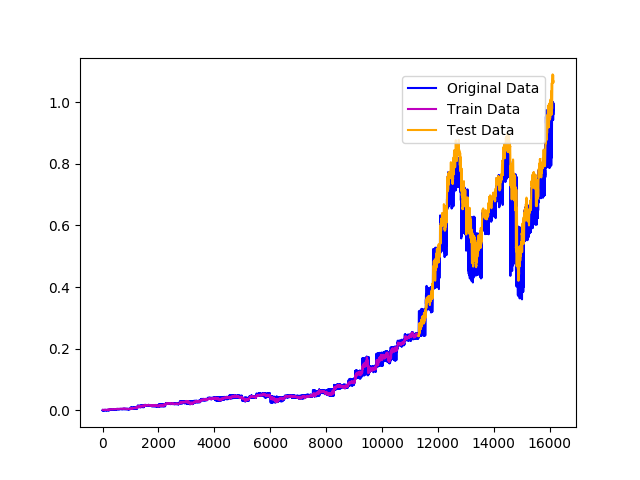

In [40]:
# Plot baseline and predictions
%matplotlib notebook
plt.plot(close_dataset_norm, color='b', label='Original Data')
plt.plot(trainPredictPlot, color='m', label='Train Data')
plt.plot(testPredictPlot, color='orange', label='Test Data')
plt.legend(bbox_to_anchor=(0.65, 0.95), loc=2, borderaxespad=0.)
plt.show()

In [17]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 64)                19200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 19,265
Trainable params: 19,265
Non-trainable params: 0
_________________________________________________________________
None


In [18]:
scores = model.evaluate(testX, testY, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
print("%s: %.2f%%" % (model.metrics_names[0], scores[0]*100))

acc: 0.02%
loss: 0.62%
